# 1. Modules

## 1.1. Load basics

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

## 1.2. Load library modules

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import copy

from magrec.misc.plot import plot_n_components
from magrec.transformation.Bxyz2Jxy import Bxyz2Jxy
from magrec.transformation.Bsensor2Jxy import Bsensor2Jxy
from magrec.transformation.MagneticFields import MagneticFields 

from magrec.misc.data import Data
from magrec import __datapath__

# 2. Data

## 2.1. Load Data¶

We'll be working with the Nb wire dataset, which has three components of the magnetic field known, and known simulated NV orientation angle. There's also a plausible reconstruction available in the notebook `Test_Magnetic_Field_Recon.ipynb`. The goal of this notebook is to achieve a similar or better performance by optimization.

First we load the data and look at what we want to reconstruct the current from:

In [16]:
__datapath__

WindowsPath('C:/Users/E123108/Dropbox/Programming/Python/magrec/database')

In [17]:
Bx = np.loadtxt(__datapath__ / "experimental" / "NbWire" / "Bx.txt")
By = np.loadtxt(__datapath__ / "experimental" / "NbWire" / "By.txt")
Bz = np.loadtxt(__datapath__ / "experimental" / "NbWire" / "Bz.txt")

B = np.empty(shape=(3, 201, 201))

sensor_theta = np.deg2rad(54.7)
sensor_phi = np.deg2rad(45)

unv = [np.sin(sensor_theta) * np.cos(sensor_phi),
       np.sin(sensor_theta) * np.sin(sensor_phi),
       np.cos(sensor_theta)]

B[0, :, :] = 1e-4*(np.rot90(Bx))
B[1, :, :] = 1e-4*(np.rot90(By))
B[2, :, :] = 1e-4*(np.rot90(Bz))
Bsensor = np.flipud(Bx*unv[0] + By*unv[1] + Bz*unv[2])

sensor_theta = 0
sensor_phi = 0 

dx = 0.4
dy = 0.4
height = 0.1
thickness = 0

dataset = Data()
dataset.load_data(
       B, 
       dx, 
       dy, 
       height, 
       sensor_theta, 
       sensor_phi, 
       thickness)

dataset.remove_DC_background()
# dataset.add_hanning_filter(0.4)

# dataset.crop_data((1,198,1,198))
# dataset.pad_data_to_power_of_two()
# dataset.pad_reflective2d()
# dataset.plot_target()

Applied a high frequency filter, removing all components smaller than 0.1 um


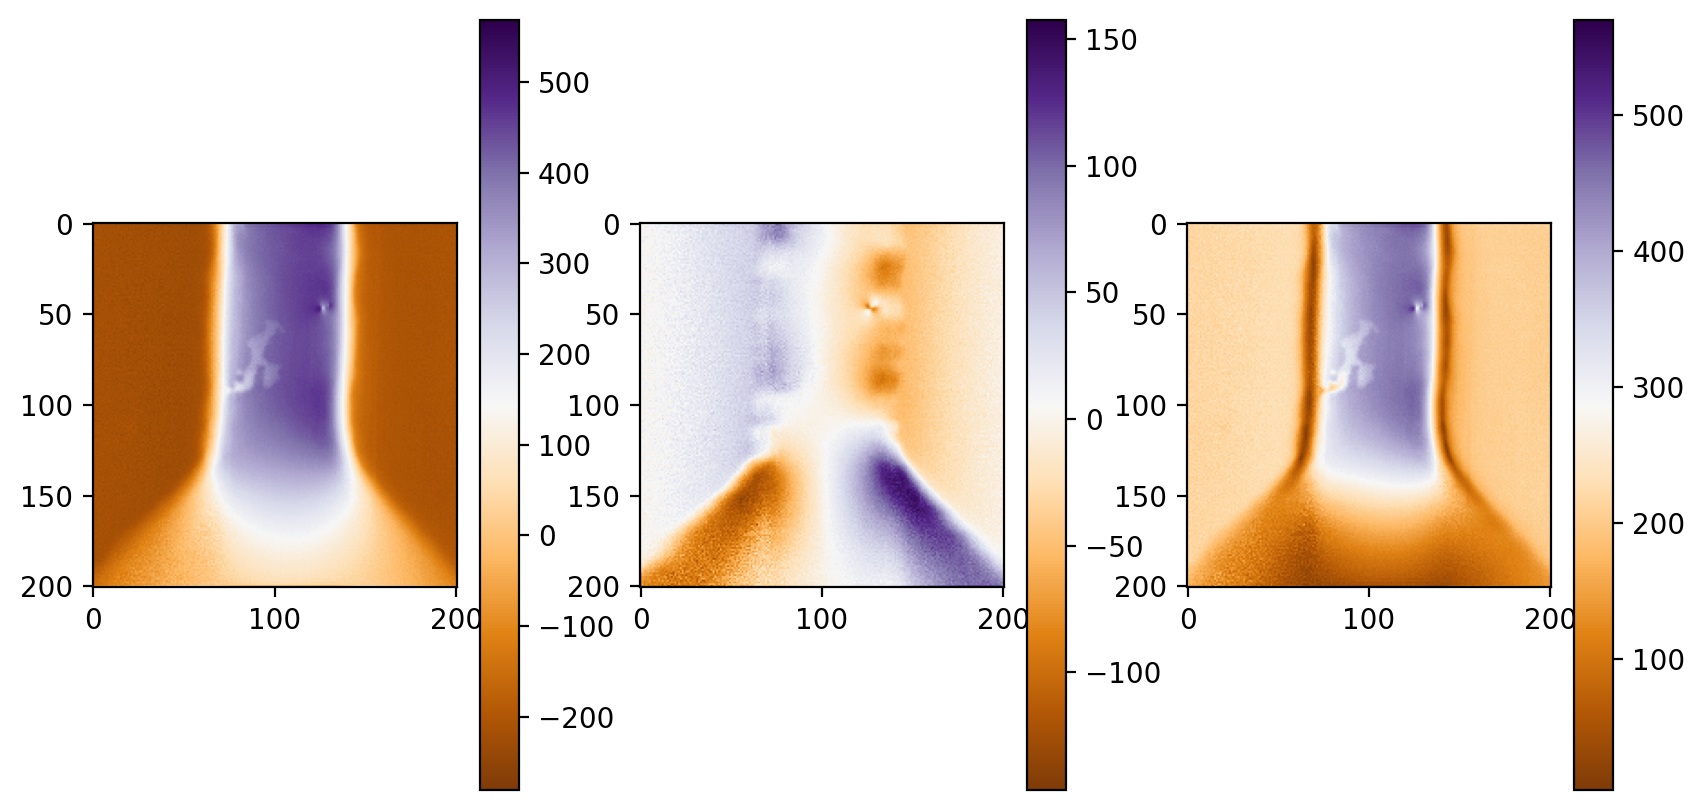

In [18]:
dataset2 = copy.deepcopy(dataset)
dataset2.set_transformer(Bxyz2Jxy)
dataset2.transform_data()

J = torch.sqrt(dataset2.transformed_target[0,...]**2 + dataset2.transformed_target[1,...]**2)

# set the figure size
plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
plt.imshow((dataset2.transformed_target[0,...]),  cmap='PuOr')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow((dataset2.transformed_target[1,...]), cmap='PuOr')
plt.colorbar()


plt.subplot(1,3,3)
plt.imshow(J, cmap='PuOr')
plt.colorbar()

In [82]:
# check the actions that have been applied to the dataset
dataset.actions

action type  reverseable reverse action   
0             load_data        False           None  \
1  remove_DC_background        False           None   

                               description parameters  
0                          loaded the data       None  
1  Removed the DC background from the data       None

In [83]:
print(len(dataset.target.size()))

3


## Reconstruct the current density using a neural network using Bz data

In [96]:
from magrec.method.FCNN import FCNN
from magrec.models.Jxy import Jxy

sensor_theta = 0
sensor_phi = 0 

dx = 0.4
dy = 0.4
height = 0.1
thickness = 0

dataset2 = Data()
dataset2.load_data(
       B[2,::] , 
       dx, 
       dy, 
       height, 
       sensor_theta, 
       sensor_phi, 
       thickness)

dataset2.remove_DC_background()
dataset2.add_hanning_filter(0.1)
dataset2.crop_data((2,198,2,198))
# dataset.pad_reflective2d()
# dataset2.pad_data_to_power_of_two()
# dataset2.plot_target()

In [97]:
dataset2.actions

action type  reverseable reverse action   
0             load_data        False           None  \
1  remove_DC_background        False           None   
2        hanning_filter        False           None   
3             crop_data        False      crop_data   

                                         description            parameters  
0                                    loaded the data                  None  
1            Removed the DC background from the data                  None  
2  Applied a low frequency filter, removing all c...      wavelength = 0.1  
3    crop the data with the given region of interest  roi = [2,198,2,198,]

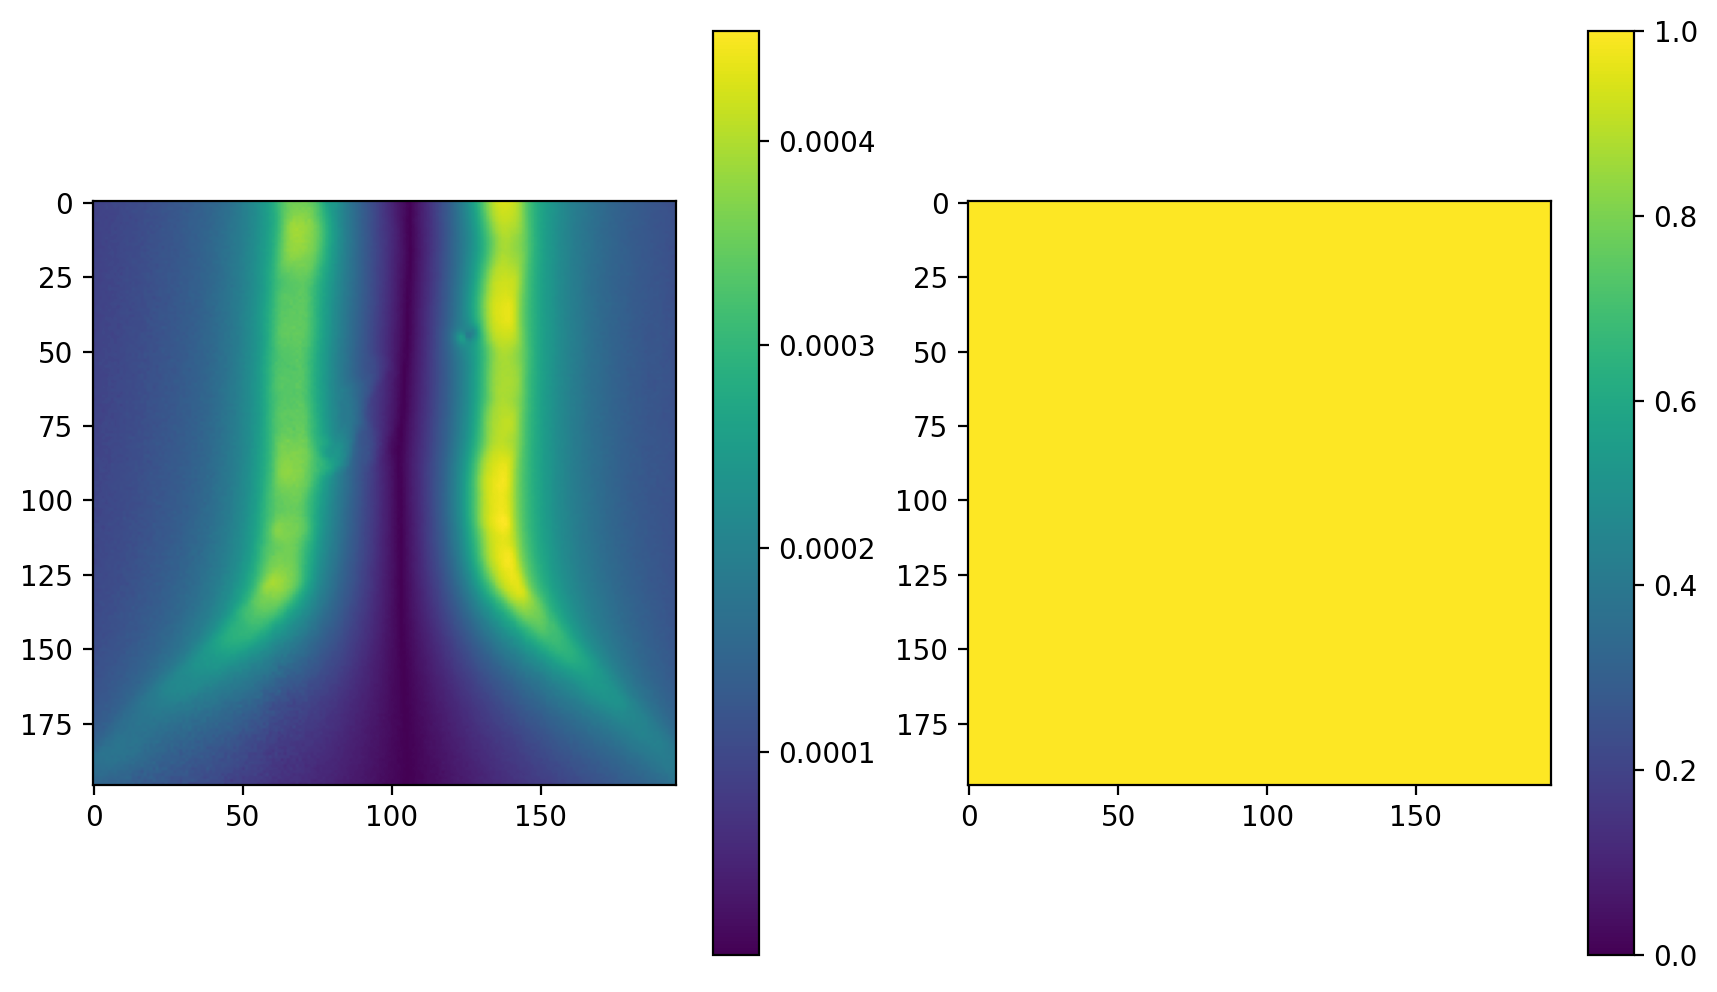

In [98]:
import magrec.image_processing.Masks as Masks
weight1 = Masks.mask_hor_dir(dataset2.target, 0.00005,  plot=True)

# weight2 = Masks.mask_vert_dir(dataset2.target, 0.00001,  plot=True)
weight = weight1

In [109]:
Model = Jxy(dataset2, "MSE")
FittingMethod = FCNN(Model, dataset2)
FittingMethod.prepare_fit()
# FittingMethod.prepare_fit()

Applied a high frequency filter, removing all components smaller than 0.1 um
Number of sources: 2
Number of targets: 1


In [110]:
FittingMethod.fit(n_epochs=100)

epoch     1 | loss on last mini-batch:  3.77e+04
epoch    11 | loss on last mini-batch:  3.77e+04
epoch    21 | loss on last mini-batch:  3.77e+04
epoch    31 | loss on last mini-batch:  3.77e+04


KeyboardInterrupt: 

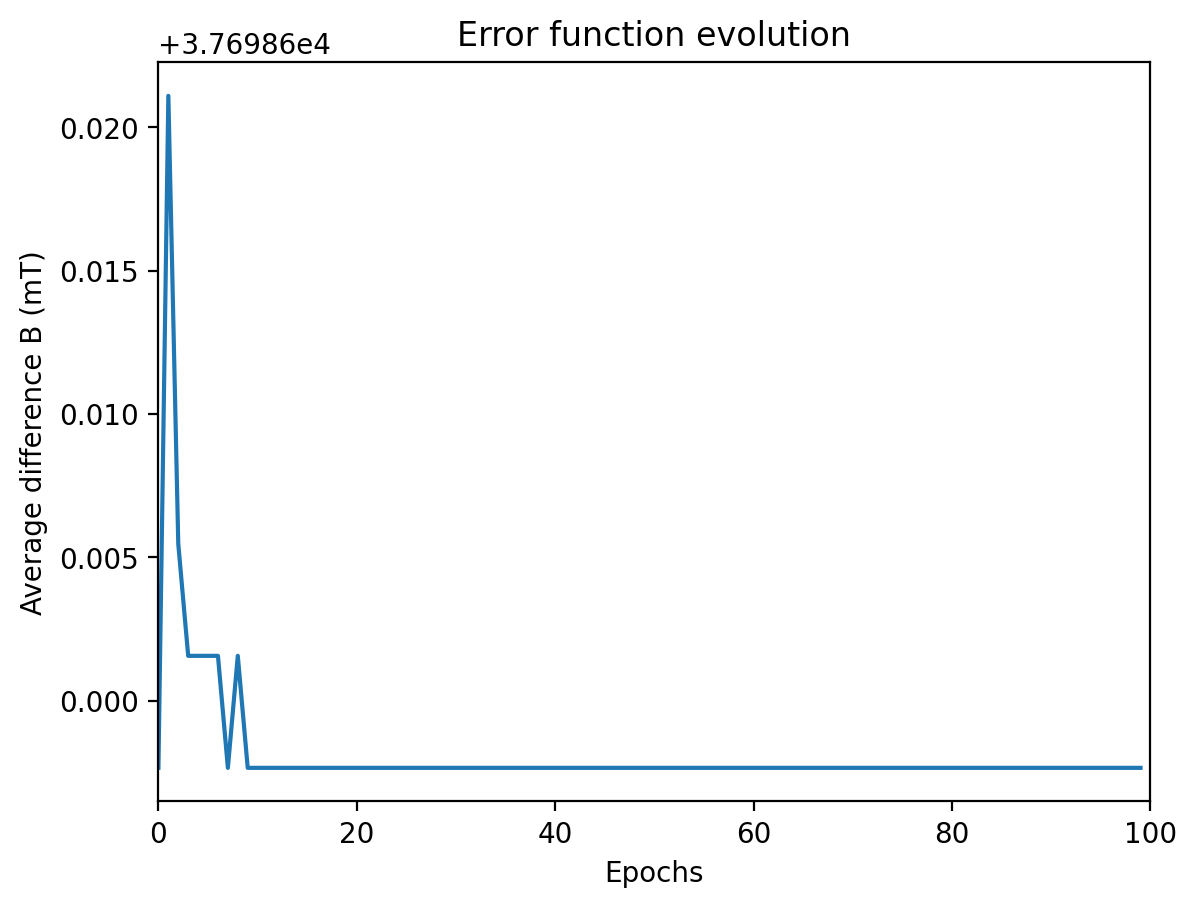

In [107]:
FittingMethod.plot_loss()

Removed the padding that was applied to the data


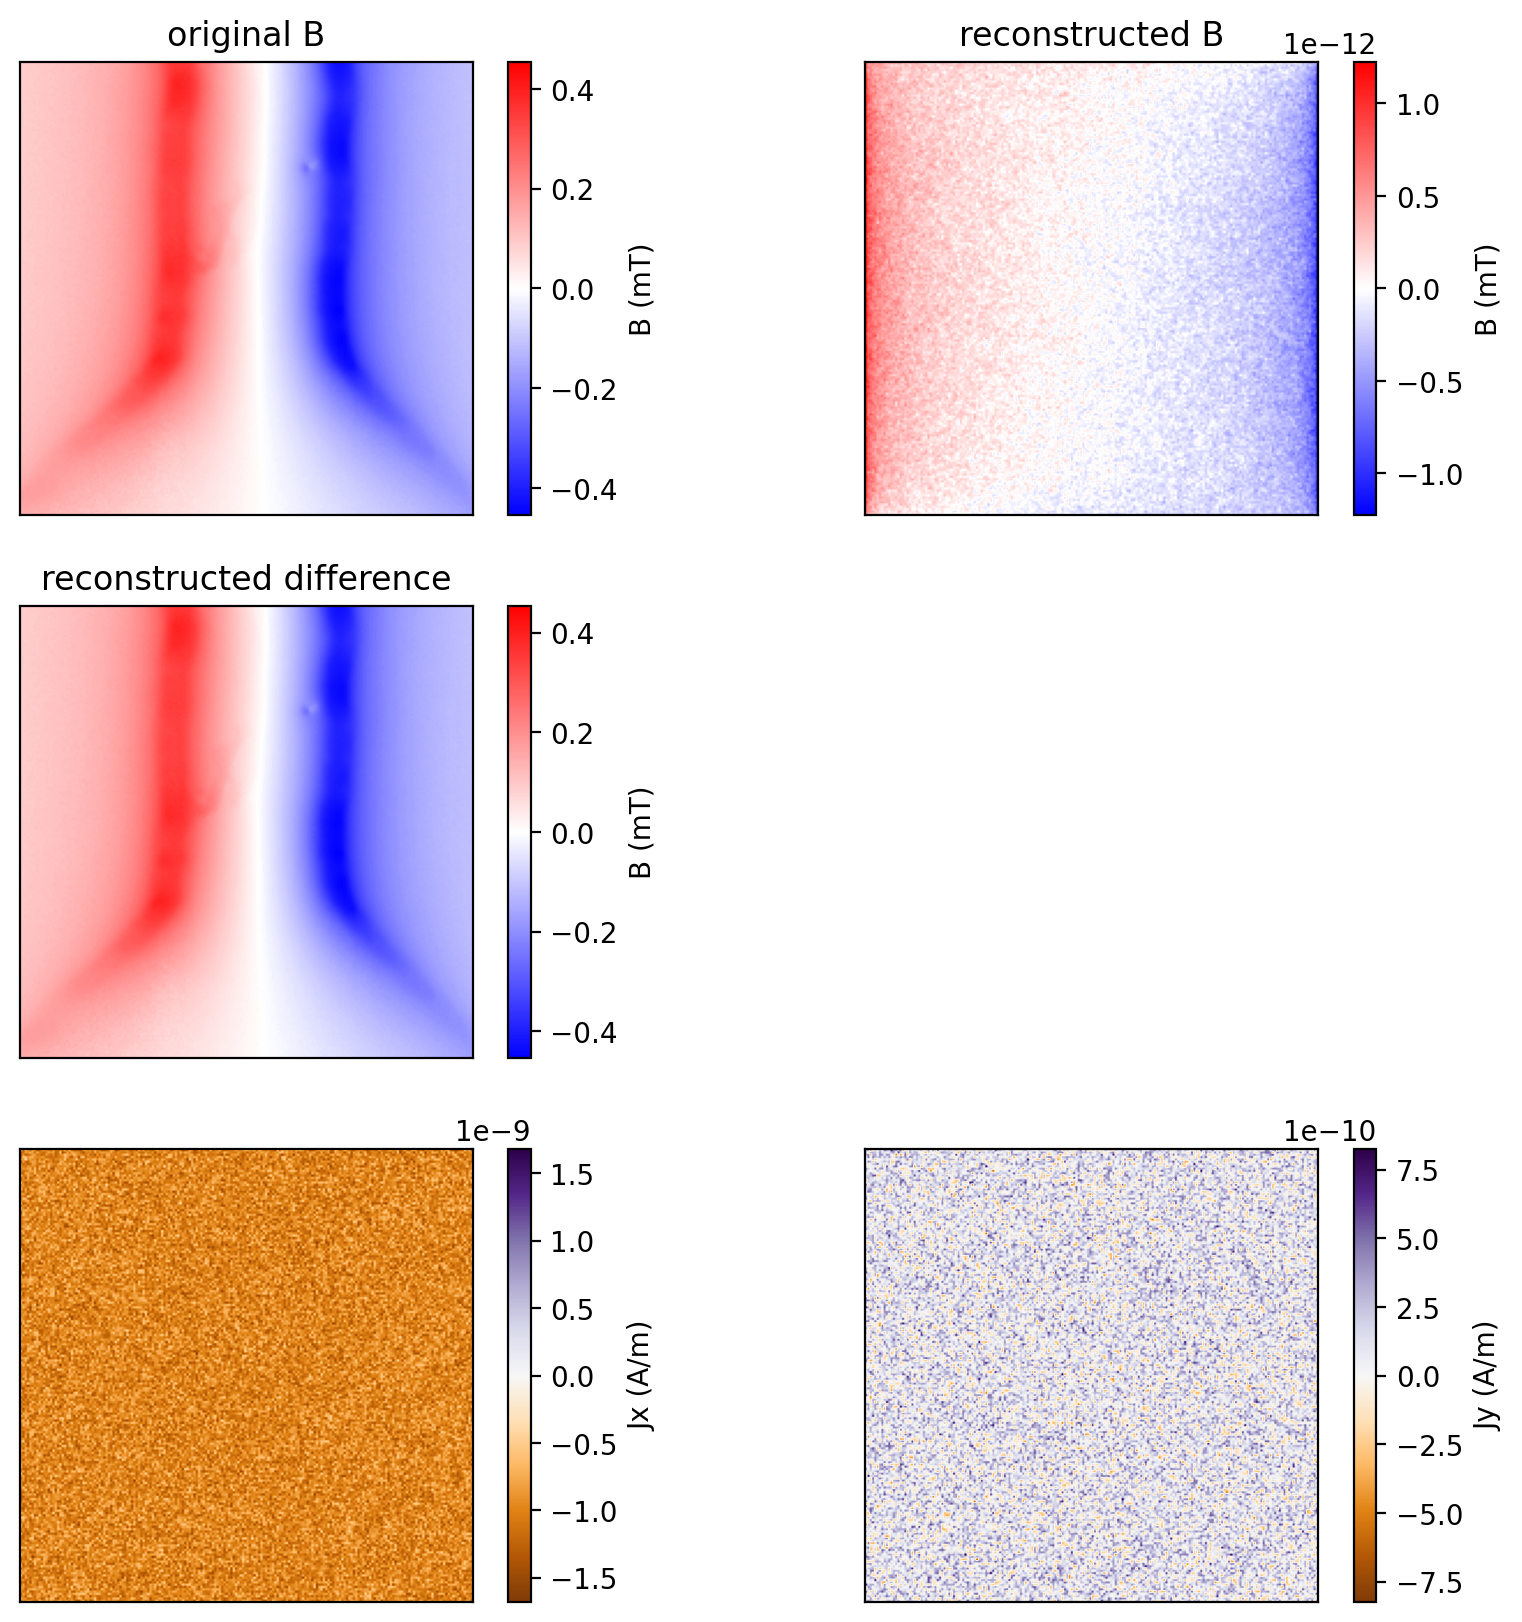

In [108]:
FittingMethod.extract_results(remove_padding=True)
FittingMethod.plot_results()

# Now try recon in Fourier space

In [ ]:
from magrec.method.FCNN import FCNN
from magrec.models.JxyFspace import JxyFspace as Jrecon


dataset5 = copy.deepcopy(dataset2)
dataset5.target = dataset5.target*1e-2

Model = Jrecon(dataset5, "MSE")
FittingMethod2 = FCNN(Model, dataset5)
FittingMethod2.prepare_fit()

Number of sources: 2
Number of targets: 1


In [ ]:
FittingMethod2.fit(n_epochs=100)

C:\Users\parax\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 1, 512, 514])) that is different to the input size (torch.Size([1, 512, 514])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch     1 | loss on last mini-batch:  1.86e+03
epoch    11 | loss on last mini-batch:  1.83e+03
epoch    21 | loss on last mini-batch:  1.62e+03
epoch    31 | loss on last mini-batch:  1.27e+03
epoch    41 | loss on last mini-batch:  9.03e+02
epoch    51 | loss on last mini-batch:  7.21e+02
epoch    61 | loss on last mini-batch:  6.67e+02
epoch    71 | loss on last mini-batch:  6.53e+02
epoch    81 | loss on last mini-batch:  6.49e+02
epoch    91 | loss on last mini-batch:  6.47e+02


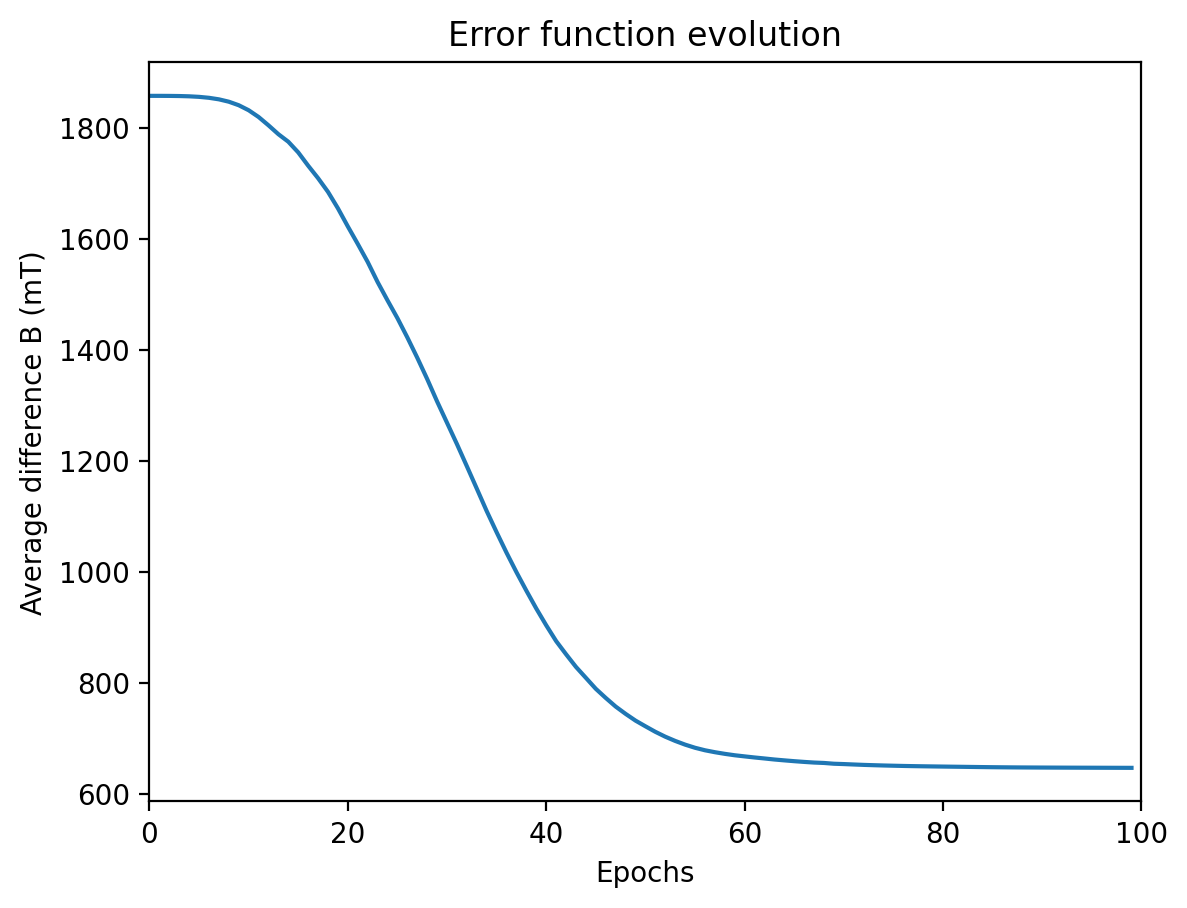

In [ ]:
FittingMethod2.plot_loss()

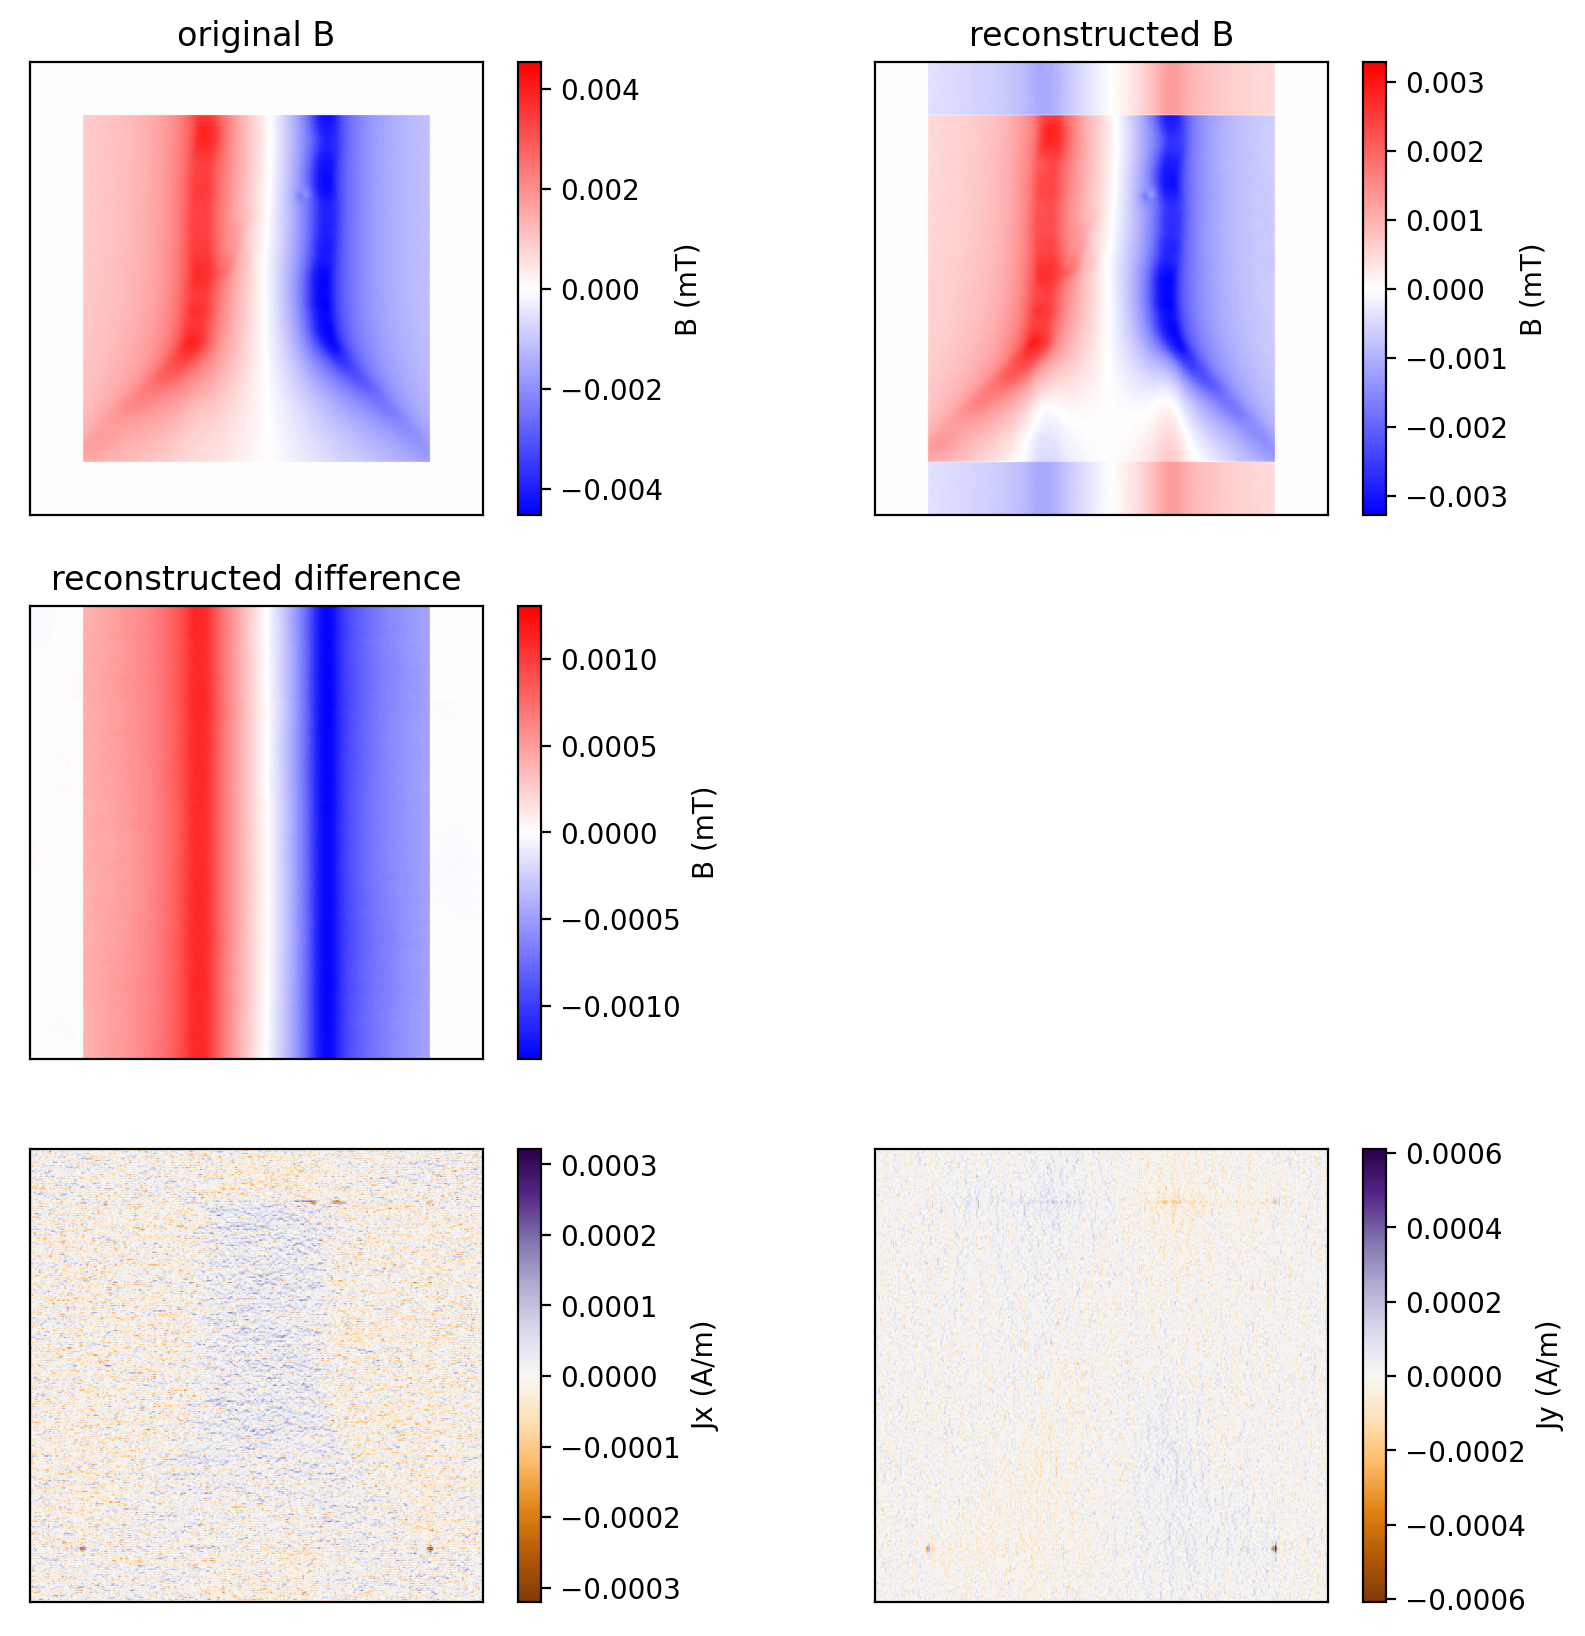

: 

In [ ]:
FittingMethod2.extract_results(remove_padding=False)

FittingMethod2.plot_results()

RuntimeError: The size of tensor a (514) must match the size of tensor b (256) at non-singleton dimension 1

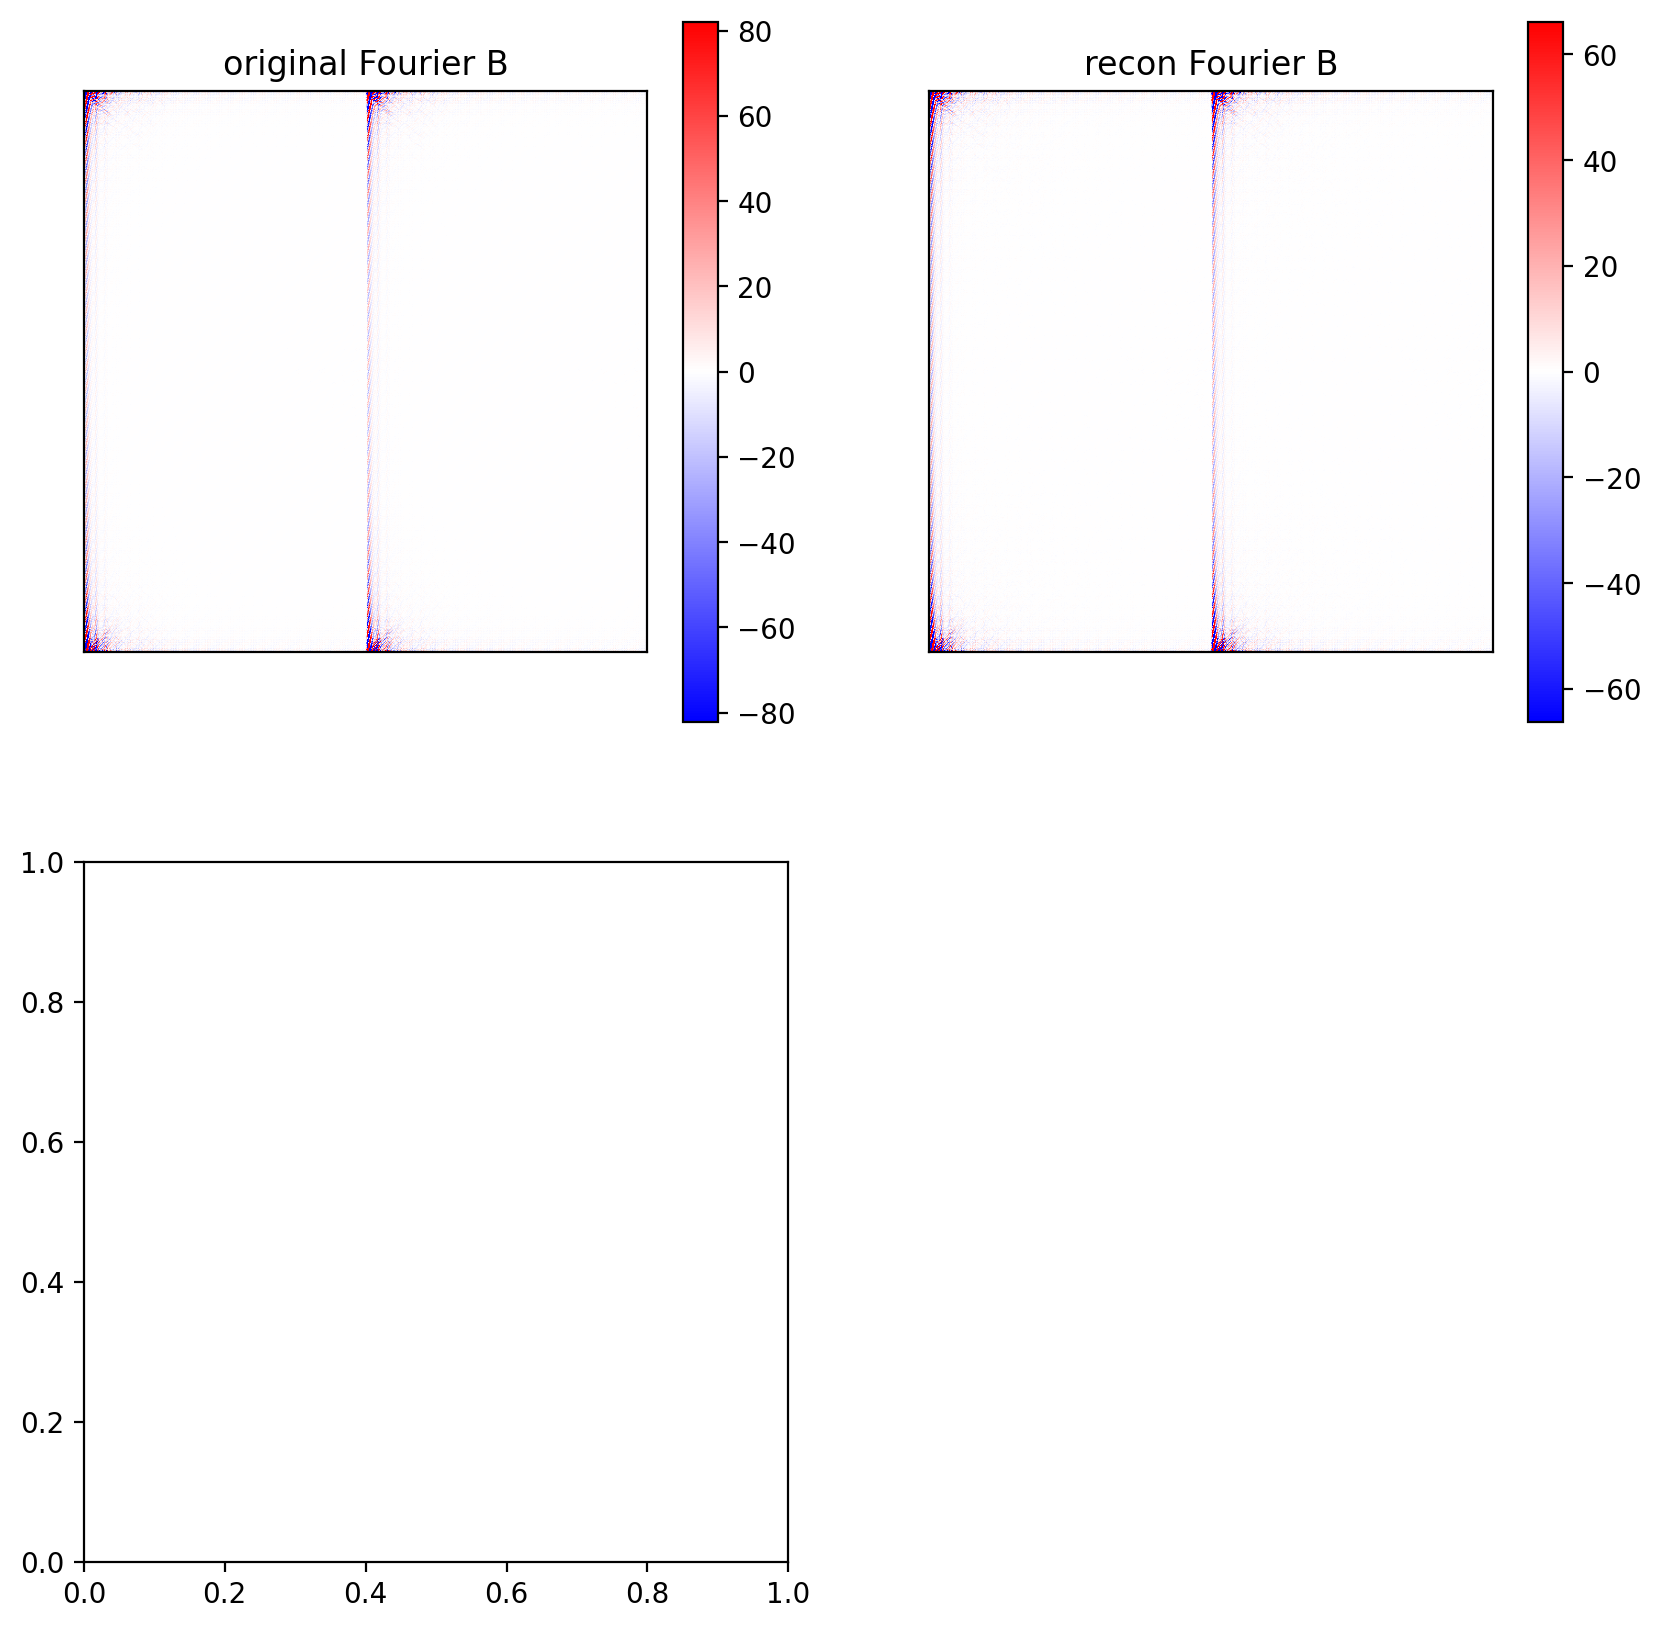

In [ ]:
fig = plt.figure()
fig.set_size_inches(10, 10)
plt.subplot(2, 2, 1)
plot_data = FittingMethod2.img_comp[0,0,::]
plot_range = abs(plot_data).max() / 100
plt.imshow(plot_data, cmap="bwr", vmin=-plot_range, vmax=plot_range)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar()
plt.title('original Fourier B')

plt.subplot(2, 2, 2)
plot_data = FittingMethod2.final_b[0,::]
plot_range = abs(plot_data).max() / 100
plt.imshow(plot_data, cmap="bwr", vmin=-plot_range, vmax=plot_range)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar()
plt.title('recon Fourier B')

plt.subplot(2, 2, 3)
plot_data = FittingMethod2.img_comp[0,0,::] - FittingMethod.final_b[0,::]
plot_range = abs(plot_data).max() /1000
plt.imshow(plot_data, cmap="bwr", vmin=-plot_range, vmax=plot_range)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar()
plt.title('Difference')
